In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import numpy as np
import pandas as pd
df = pd.read_parquet('data/eurovision-33columns-grouped.parquet')
df[df['year'] == 2010].head()

,year,round,to_country_id,to_country,total_points,id,artist,title,country,path,...,log_norm_ioi.mean,log_norm_ioi.std,log_norm_ioi.hist.mean,log_norm_ioi.hist.std,beats.mean,beats.std,onsets.mean,onsets.std,song.id,segment.id
942,2010,final,al,Albania,62,670,Juliana Pasha,It's All About You,Albania,dataset/eurovision/2010/Albania_It's All About...,...,-1.049794,2.639398,-1.049794,2.639398,2.804729,-0.635890,2.085281,2.713295,670,670
943,2010,semi-final-1,al,Albania,76,670,Juliana Pasha,It's All About You,Albania,dataset/eurovision/2010/Albania_It's All About...,...,-1.049794,2.639398,-1.049794,2.639398,2.804729,-0.635890,2.085281,2.713295,670,670
944,2010,final,am,Armenia,141,669,Eva Rivas,Apricot Stone,Armenia,dataset/eurovision/2010/Armenia_Apricot Stone_...,...,1.213333,3.206770,1.213333,3.206770,-0.626311,-0.081032,1.887110,1.783929,669,669
945,2010,semi-final-2,am,Armenia,83,669,Eva Rivas,Apricot Stone,Armenia,dataset/eurovision/2010/Armenia_Apricot Stone_...,...,1.213333,3.206770,1.213333,3.206770,-0.626311,-0.081032,1.887110,1.783929,669,669
946,2010,final,az,Azerbaijan,145,683,Safura,Drip Drop,Azerbaijan,dataset/eurovision/2010/Azerbaijan_Drip Drop_S...,...,0.891607,1.919757,0.891607,1.919757,-1.035883,-0.438358,0.468064,1.023641,683,683


In [3]:
from eurovision_dataset import EurovisionDatasetGrouped

feature_columns = ['loudness.mean', 'loudness.mean.corpus.pdf.rank.logit', 'loudness.std',
       'loudness.std.corpus.pdf.rank.logit',
       'pitchhist3_int.corpus.information', 'pitchhist3_int.corpus.tau',
       'pitchhist3.normentropy.minlog',
       'pitchhist3.normentropy.minlog.corpus.pdf.rank.logit',
       'mfcc.mean.corpus.indeppdf.rank.logit', 'mfcc.totvar.log',
       'mfcc.totvar.log.corpus.pdf.rank.logit', 'melody.mean',
       'melody.mean.corpus.pdf.rank.logit', 'melody.std.log',
       'melody.std.log.corpus.pdf.rank.logit', 'roughness.mean.log',
       'roughness.mean.log.corpus.pdf.rank.logit', 'sharpness.mean',
       'sharpness.mean.corpus.pdf.rank.logit', 'tempo.mean', 'tempo.std',
       'rpvi.mean', 'rpvi.std', 'npvi.mean', 'npvi.std', 'log_norm_ioi.mean',
       'log_norm_ioi.std', 'log_norm_ioi.hist.mean', 'log_norm_ioi.hist.std',
       'beats.mean', 'beats.std', 'onsets.mean', 'onsets.std']

dataset = EurovisionDatasetGrouped(df, feature_columns)

In [5]:
from torch.utils.data import random_split

print("Dataset length: " + str(len(dataset)))
test_set_size = 23
train_set, test_set = random_split(dataset, [len(dataset) - test_set_size, test_set_size])

Dataset length: 73


In [6]:
# Some random sample
sample_input, sample_order = train_set[0]
print(sample_input)
print(sample_order)

tensor([[-3.8355e-01,  1.0289e+00, -1.8094e-01,  4.9327e-01,  1.7915e-01,
         -8.3254e-01, -5.2371e-01,  3.2020e-01, -2.1899e-01,  8.6615e-01,
         -4.6769e-01, -2.1900e-01,  2.0659e+00,  3.0944e-01,  1.1871e+00,
         -7.0930e-02,  1.5814e-01, -9.7799e-01, -6.1524e-01,  1.1560e+00,
          2.2446e-01, -4.0754e-01,         nan, -3.3814e-01,         nan,
          7.9355e-01,  1.1584e-01,  7.9355e-01,  1.1584e-01, -1.0035e+00,
         -5.9377e-01, -1.8507e-01, -2.9525e-01],
        [-4.9268e-01,  1.9287e+00, -2.5903e-01,  6.2693e-01,  6.3883e-01,
         -1.5171e+00,  4.5985e-01,  2.2398e-01,  3.9517e-01, -3.4640e-01,
          1.8553e+00,  2.9188e-03,  8.8129e-01, -7.1187e-01, -3.2485e-01,
         -2.3424e-01,  1.3407e-01,  1.1630e+00, -4.1873e-01,  1.7274e-01,
          1.4719e+00, -4.3263e-01,         nan, -1.1719e-01,         nan,
         -2.5795e-01, -1.9101e-01, -2.5795e-01, -1.9101e-01, -3.3950e-01,
          8.2990e-01, -5.8052e-01, -4.6751e-01],
        [ 3.32

In [7]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, shuffle=True)
test_loader = DataLoader(test_set)

In [18]:
import torch
from linear_model import LinearModel
from exploded_logit import ExplodedLogitLoss
from torch.utils.tensorboard import SummaryWriter

loss_type = 'nll'
regularization_lambda = 0.001

writer = SummaryWriter('runs/33columns-grouped/' + loss_type)

linear_model = LinearModel(33, 1)  # number of columns to score
optimizer = torch.optim.Adam(params=linear_model.parameters())
loss = ExplodedLogitLoss(loss_type=loss_type)

for epoch in range(500):
    for step, (data, order) in enumerate(train_loader):
        data[torch.isnan(data)] = 0
        
        optimizer.zero_grad()
        score = linear_model(data).squeeze(-1)
        
        loss_value = loss(score, order)
        
        l1_loss_value = 0
        for param in linear_model.parameters():
            l1_loss_value += torch.sum(torch.abs(param))
        loss_value += regularization_lambda * l1_loss_value
        
        loss_value.backward()
        optimizer.step()
        
        writer.add_scalar('training loss', loss_value.item(),
                          epoch * len(train_loader) + step)
    if epoch % 100 == 0:
        print("Loss value: {0}".format(loss_value.item()))

Loss value: 42.908424454142605
Loss value: 36.77742488329183
Loss value: 38.928552752572756
Loss value: 42.588827705283094
Loss value: 37.07898387509472


In [12]:
%load_ext tensorboard

In [16]:
!kill 35278

In [19]:
%tensorboard --logdir="runs/33columns-grouped"

Reusing TensorBoard on port 6008 (pid 35300), started 0:00:55 ago. (Use '!kill 35300' to kill it.)

In [20]:
def get_sort_order(scores):
    s = torch.argsort(scores, descending=True)
    r = torch.zeros(scores.shape, dtype=torch.long)
    for i in range(scores.shape[-1]):
        r[0, s[0, i]] = i
    return r + 1

In [21]:
def precision_at_k(k, expected_order, actual_order):
    p = 0
    t = 0
    for i in range(1, k+1):
        idx = np.where(actual_order == i)
        if expected_order[idx] <= k:
            t += 1
            p += t/i
    return p/k
            
print(precision_at_k(3, np.asarray([1, 2, 3, 4, 5, 6]), np.asarray([1, 2, 3, 4, 5, 6])))
print(precision_at_k(3, np.asarray([1, 2, 3, 4, 5, 6]), np.asarray([6, 5, 4, 3, 2, 1])))
print(precision_at_k(3, np.asarray([1, 2, 3, 4, 5, 6]), np.asarray([1, 2, 4, 3, 5, 6])))
print(precision_at_k(3, np.asarray([1, 2, 3, 4, 5, 6]), np.asarray([1, 5, 4, 3, 2, 6])))
print(precision_at_k(3, np.asarray([1, 2, 3, 4, 5, 6]), np.asarray([6, 5, 1, 3, 2, 4])))
print(precision_at_k(3, np.asarray([1, 2, 3, 4, 5, 6]), np.asarray([6, 5, 2, 3, 4, 1])))
print(precision_at_k(3, np.asarray([1, 2, 3, 4, 5, 6]), np.asarray([6, 5, 3, 4, 2, 1])))

1.0
0.0
0.6666666666666666
0.3333333333333333
0.3333333333333333
0.16666666666666666
0.1111111111111111


In [22]:
test_size = len(test_loader)
at_k = 10
pk = np.zeros(at_k)  
lgths = []

num = 0
with torch.no_grad():
    for data, expected_order in test_loader:
        score = linear_model(data).squeeze(-1)
        
        actual_order = get_sort_order(score)
        
        if (len(expected_order.squeeze(0).numpy()) < 21):
            continue

        for k in range(1, at_k+1):
            p = precision_at_k(k, expected_order.squeeze(0).numpy(),
                               actual_order.squeeze(0).numpy())
            pk[k-1] += p
        
        num += 1
        lgths.append(len(expected_order.squeeze(0).numpy()))
#         print("\n{0}\n{1}\n\n".format(actual_order, expected_order.view(1, -1)))
pk = pk / num

10


(array([2., 3., 0., 2., 0., 1., 1., 0., 0., 1.]),
 array([22. , 22.6, 23.2, 23.8, 24.4, 25. , 25.6, 26.2, 26.8, 27.4, 28. ]),
 <BarContainer object of 10 artists>)

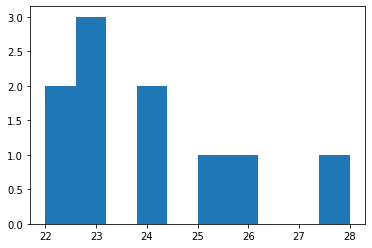

In [23]:
import matplotlib.pyplot as plt
print(len(lgths))
plt.hist(lgths)

<BarContainer object of 10 artists>

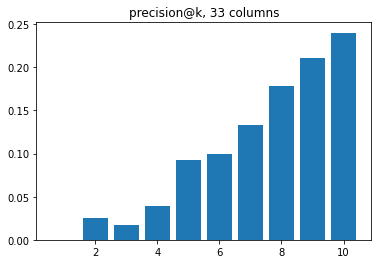

In [24]:
plt.title('precision@k, 33 columns')
plt.bar(np.arange(1, at_k+1), pk)

In [25]:
linear_model.linear.weight

Parameter containing:
tensor([[ 1.9989e-01, -2.3831e-02, -1.1659e-01, -5.9355e-02,  3.3789e-02,
          6.2629e-02,  3.2270e-02, -7.4458e-03,  4.1246e-02,  1.3554e-01,
          1.6690e-02,  1.4836e-02, -7.8735e-02,  5.1800e-02,  8.2577e-03,
         -7.1310e-02,  9.9827e-02,  3.2610e-03,  6.7156e-02, -9.2858e-03,
          3.3522e-02,  7.0265e-02, -1.4376e-04, -1.1662e-01, -1.1288e-04,
         -1.7047e-02, -1.2469e-02, -2.3837e-02,  5.3215e-02, -2.2905e-02,
          6.2474e-03, -8.0345e-02,  1.3619e-01]], requires_grad=True)